2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 3a)

### Imports, Inits, and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
jupyterNotebookEnabled = True
plotting = True

coursework, part = 4, "3a"
saving = True

In [3]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [23]:
from collections import OrderedDict
from __future__ import division
import skopt
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt
%matplotlib inline
from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats, renderStatsCollection
    
from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer, \
    trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts, factors

from mylibs.dropout_helper import constructProbs

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm
    
from skopt.space.space import Integer, Categorical
from skopt import gp_minimize

import pickle

from rnn.msd10_data_providers import MSD10Genre_120_rnn_native_DataProvider
from rnn.my_basic_rnn import MyBasicRNN

In [24]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

figcount = 0

tensorboardLogdir = 'tf_cw{}_{}'.format(coursework, part)

curDtype = tf.float32

reluBias = 0.1

batch_size = 50

### MSD 10 genre task

In [25]:
segmentCount = 120
segmentLen = 25

In [26]:
def getLogitsOfUnlabelled(batch_size, num_steps, logits, inputs, targets, sess, e,
                           error, accuracy, extraFeedDict={}):
    #batch_size = 97 #factors of 9991: [1, 103, 97, 9991]
    
    data_provider = MSD10Genre_120_rnn_native_DataProvider(
        num_steps = num_steps, which_set = 'test', batch_size=batch_size,
        shuffle_order = False
    )
    
    total_error = 0.
    total_accuracy = 0.
    
    num_batches = data_provider.num_batches
    
    #chopping off to make batch size fit exactly
    length = len(data_provider.inputs) - (len(data_provider.inputs) % batch_size)
    #np.empty
    all_logits = np.zeros((length, data_provider.num_classes))
    
    for step, (input_batch, target_batch) in enumerate(data_provider):
        batch_logits, batch_error, batch_acc = sess.run(
            [logits, error, accuracy],
            feed_dict= merge_dicts({inputs: input_batch,
                                    targets: target_batch}, extraFeedDict)
        )
        
        all_logits[step * len(batch_logits):(step+1) * len(batch_logits), :] = batch_logits
        
        total_error += batch_error
        total_accuracy += batch_acc

    total_error /= num_batches
    total_accuracy /= num_batches
    
    assert np.all(all_logits != 0) #all logits expected to be something else than zero
    
    return all_logits, total_error, total_accuracy

In [27]:
def trainValidateTest(train_data, valid_data, state_size, graph, init, logits, inputs,
                     targets, init_state, train_step, error, accuracy,
                     epochs=35, verbose=True):
    if verbose:
        print "epochs: %d" % epochs
        print "rnn steps: %d" % train_data.num_steps
        print "state size: %d" % state_size

    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init)

        stats, keys = initStats(epochs)

        for e in range(epochs):
            (train_error, train_accuracy), runTime = getRunTime(lambda : 
                    trainEpoch(
                        inputs, targets, sess, e,
                        train_data, train_step, error, accuracy, {}
                    )
            )

            if (e + 1) % 1 == 0:
                valid_error, valid_accuracy = validateEpoch(
                    inputs, targets, sess, e,
                    valid_data, error, accuracy
                )

            if verbose:
                print ('End epoch %02d (%.3f secs):err(train)=%.2f,acc(train)=%.2f,' + \
                      'err(valid)=%.2f,acc(valid)=%.2f') % \
                    (e+1, runTime, train_error, train_accuracy, valid_error, valid_accuracy)

            stats = gatherStats(e, train_error, train_accuracy,
                                valid_error, valid_accuracy, stats)
            
        test_logits, test_error, test_accuracy = getLogitsOfUnlabelled(
            batch_size, num_steps, logits, inputs, targets, sess, e, error, accuracy
        )
    
    if verbose:
        print
    
    return stats, keys, test_logits, test_error, test_accuracy

https://www.tensorflow.org/versions/r0.12/api_docs/python/nn/recurrent_neural_networks#rnn

In [28]:
myBasicRNN = MyBasicRNN(batch_size=batch_size, rng=rng, dtype=curDtype, config=config,
                       segment_count=segmentCount, segment_len = segmentLen)

In [10]:
show_graph(myBasicRNN.loadAndGetGraph(num_steps = 8, state_size = 15))

In [10]:
def rnn_native_tf_with_test(state_size, num_steps, epochs):
    train_data = get_dp('train', num_steps)
    valid_data = get_dp('valid', num_steps)
    
    graph, init, inputs, targets, init_state, \
        train_step, error, accuracy, logits = \
        getGraph(num_steps=num_steps, train_data=train_data, state_size=state_size)

    stats, keys, test_logits, test_error, test_accuracy = trainValidateTest(
        train_data, valid_data, state_size, graph, init, logits, inputs,
        targets, init_state, train_step, error, accuracy, epochs=epochs
    )
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
#         figcount += 1
#         if saving:
#             fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
#             fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))

    return stats, keys, test_logits, test_error, test_accuracy

### Exploration of best state size and best num of steps RNN with Bayesian Optimization

In [11]:
steps_possible = np.sort(factors(segmentCount))[1:-1]
assert np.all( segmentCount % steps_possible == 0 )
print len(steps_possible)
steps_possible

14


array([ 2,  3,  4,  5,  6,  8, 10, 12, 15, 20, 24, 30, 40, 60])

In [12]:
stateSizeSpace = Integer(15, 1000)
numStepSpace = Categorical(steps_possible)
space  = [stateSizeSpace, numStepSpace]

In [13]:
def objective(params): # Here we define the metric we want to minimise    
    (state_size, num_steps) = params
    
    stats, keys = myBasicRNN.rnn_native_tf(
        state_size = state_size,
        num_steps = num_steps,
        epochs = 30
    )
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
    
    #save everytime in case it crashes
    filename = 'rnn_native_bay_opt_stateSize_numSteps_statsCollection.npy'
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[(state_size, num_steps)] = stats
    np.save(filename, statsCollection)
    
    # We want to maximise validation accuracy, i.e. minimise minus validation accuracy
    validAccs = stats[:, -1]
    length10percent = len(validAccs) // 10
    best10percent = np.sort(validAccs)[-length10percent:]
    return -np.mean(best10percent)

In [14]:
res_gp_save_filename = 'res_gp_rnn_native.pickle'
best_params_filename = 'best_params_rnn_native.npy'

In [15]:
%%time

if not os.path.isfile(best_params_filename):
    res_gp = gp_minimize(
            func=objective, # function that we wish to minimise
            dimensions=space, #the search space for the hyper-parameters
            #x0=x0, #inital values for the hyper-parameters
            n_calls=30, #number of times the function will be evaluated
            random_state = seed, #random seed
            n_random_starts=5,
                #before we start modelling the optimised function with a GP Regression
                #model, we want to try a few random choices for the hyper-parameters.
            kappa=1.9 #trade-off between exploration vs. exploitation.
        )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 136 µs


In [16]:
if os.path.isfile(best_params_filename):
    best_params = np.load(best_params_filename)
else:
    np.save(best_params_filename, res_gp.x)
    best_params = res_gp.x

In [17]:
if os.path.isfile(res_gp_save_filename):
    with open(res_gp_save_filename) as f:  # Python 3: open(..., 'rb')
        (res_gp, ) = pickle.load(f)
else:
    with open(res_gp_save_filename, 'w') as f:  # Python 3: open(..., 'wb')
        pickle.dump([res_gp], f)

In [18]:
best_params

array([359,  60])

In [19]:
from skopt.plots import plot_convergence

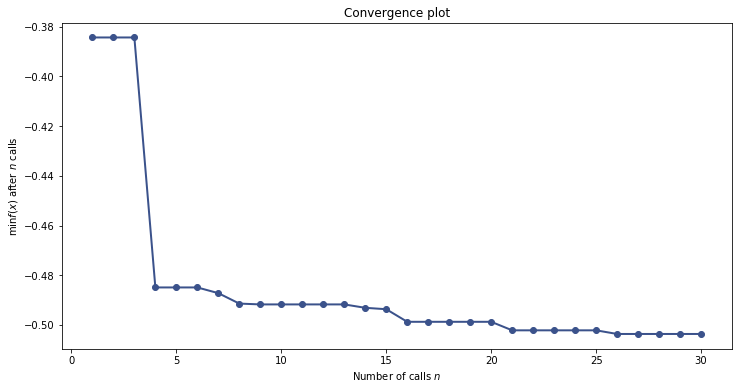

In [32]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_convergence_plot.svg'.format(coursework, part))

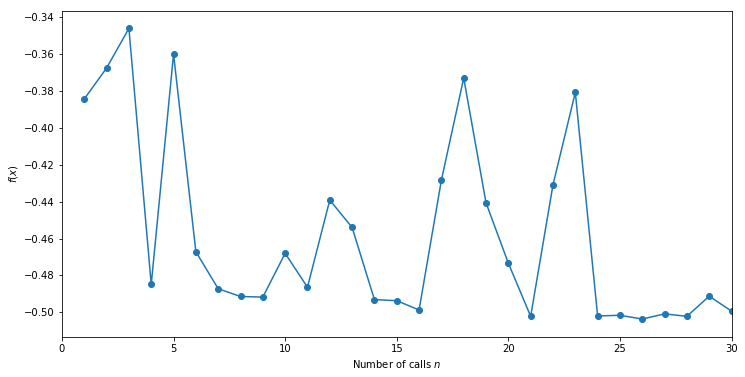

In [31]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.arange(len(res_gp.func_vals))+1, res_gp.func_vals)
    plt.scatter(np.arange(len(res_gp.func_vals))+1, res_gp.func_vals)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_func.svg'.format(coursework, part))

In [33]:
filename = 'rnn_native_bay_opt_stateSize_numSteps_statsCollection.npy'
statsCollection = np.load(filename)[()]

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:163: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:165: MatplotlibDeprecationWarning:

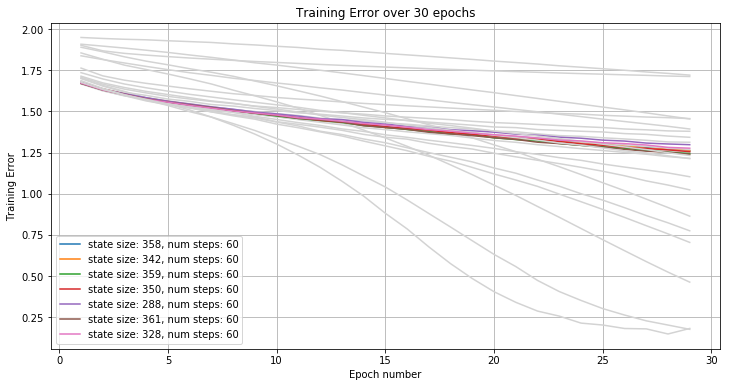

In [36]:
key = "error(train)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Training Error",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

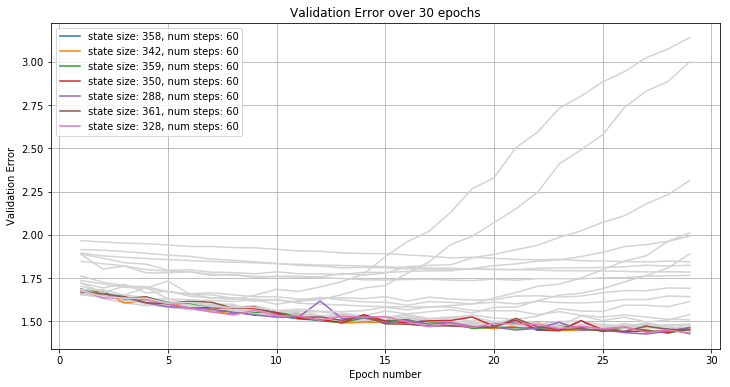

In [37]:
key = "error(valid)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Validation Error",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

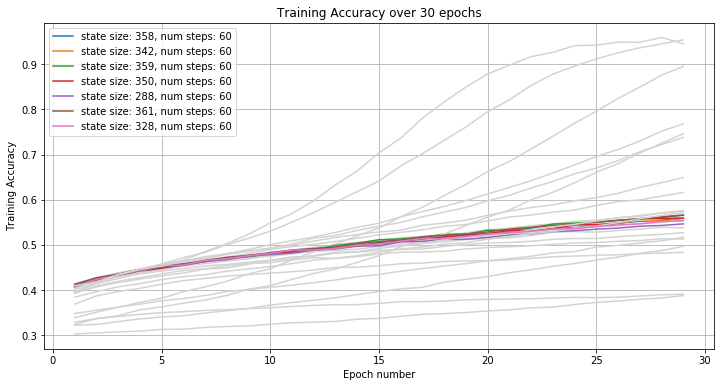

In [38]:
key = "acc(train)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Training Accuracy",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

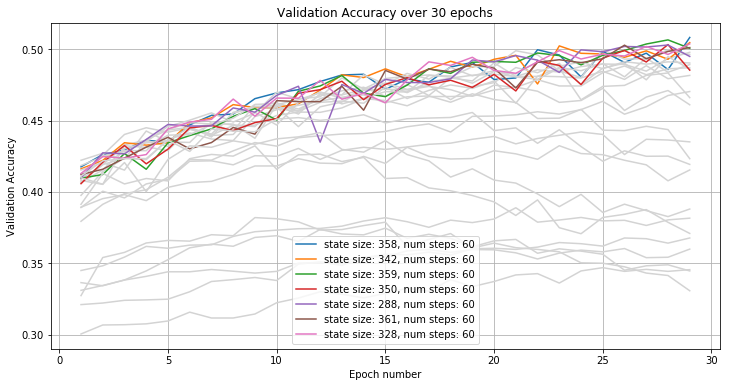

In [39]:
key = "acc(valid)"
fig = renderStatsCollection(statsCollection, epochs = 30, title = "Validation Accuracy",
                      k = key)
if saving:
    fig.savefig('cw{}_part{}_fig_bayes_opt_{}.svg'.format(coursework, part, key))

## Train best parameters classifier with native tensorflow RNN

epochs: 50
rnn steps: 60
state size: 359
End epoch 01 (62.853 secs): err(train)=1.80, acc(train)=0.36, err(valid)=1.73, acc(valid)=0.38, 
End epoch 02 (43.415 secs): err(train)=1.67, acc(train)=0.41, err(valid)=1.73, acc(valid)=0.39, 
End epoch 03 (40.938 secs): err(train)=1.64, acc(train)=0.42, err(valid)=1.66, acc(valid)=0.42, 
End epoch 04 (40.216 secs): err(train)=1.61, acc(train)=0.43, err(valid)=1.65, acc(valid)=0.42, 
End epoch 05 (40.580 secs): err(train)=1.58, acc(train)=0.44, err(valid)=1.64, acc(valid)=0.42, 
End epoch 06 (40.964 secs): err(train)=1.56, acc(train)=0.45, err(valid)=1.60, acc(valid)=0.44, 
End epoch 07 (40.533 secs): err(train)=1.54, acc(train)=0.46, err(valid)=1.58, acc(valid)=0.45, 
End epoch 08 (40.080 secs): err(train)=1.52, acc(train)=0.46, err(valid)=1.58, acc(valid)=0.45, 
End epoch 09 (40.636 secs): err(train)=1.50, acc(train)=0.47, err(valid)=1.56, acc(valid)=0.46, 
End epoch 10 (40.196 secs): err(train)=1.48, acc(train)=0.48, err(valid)=1.57, acc(val

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:74: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(True)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:78: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(False)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:87: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_2.hold(True)
/home/studenthp/pligor.george@gma

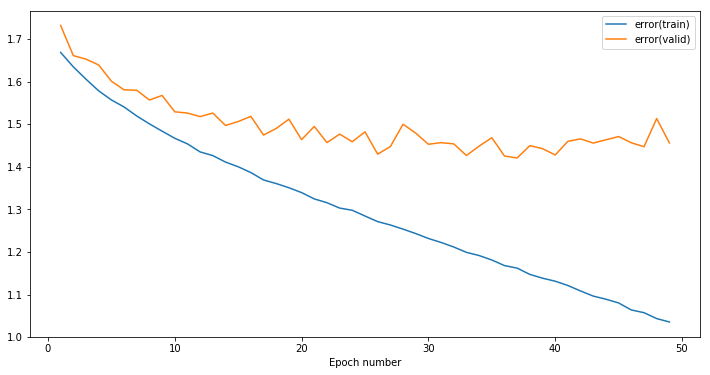

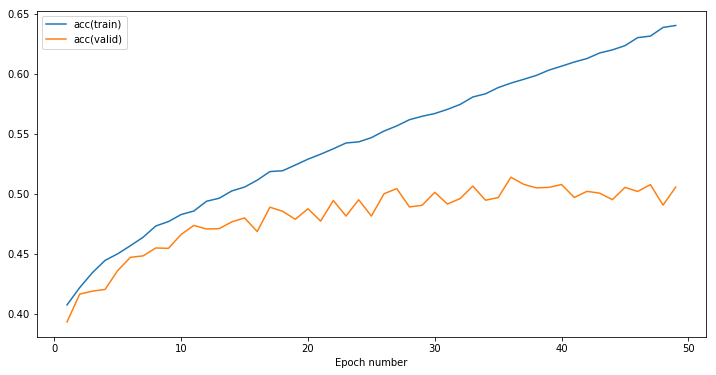

TypeError: %d format: a number is required, not str

In [29]:
%%time

(state_size, num_steps) = best_params

# stats, keys, test_logits, test_error, test_accuracy = rnn_native_tf_with_test(
#     state_size = state_size,
#     num_steps = num_steps,
#     epochs = 50
# )

stats, keys = myBasicRNN.rnn_native_tf(
    state_size = state_size,
    num_steps = num_steps,
    epochs = 50
)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    plt.show()      
    if saving:
        figcount += 1
        fig_1.savefig('cw{}_part{}_{:02d}_fig_error.svg'.format(coursework, part, figcount))
        fig_2.savefig('cw{}_part{}_{:02d}_fig_valid.svg'.format(coursework, part, figcount))

In [40]:
print max(stats[:, -1])

0.514099985212
